In [ ]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn

## 1. Make classification data and get it ready

In [ ]:
# Creating data:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

## 2. Turning our data into Tensors and making a training-test split

In [ ]:
# turn data into tensors:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# split data into training and test sets:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 3. Setting up device agnostic

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 4. Creating the model

In [ ]:
# create the model:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # create 2 nn.Linear layers :
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


In [ ]:
# Instantiate an instance of our model and send it to device:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

## 5. Recreate the model using nn.sequential

In [ ]:
# create the model using nn.Sequential:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# model_paramaters:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5210,  0.3276],
                      [ 0.1494, -0.5480],
                      [ 0.4002,  0.5266],
                      [-0.1362,  0.5478],
                      [-0.0070,  0.3887]])),
             ('0.bias', tensor([ 0.1848, -0.0399, -0.0193, -0.2752,  0.4211])),
             ('1.weight',
              tensor([[ 0.2148,  0.1180, -0.0849,  0.0998,  0.0960]])),
             ('1.bias', tensor([-0.2515]))])

In [ ]:
# Make some predictions:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))


## 6. Setup loss function and an optimizer

In [ ]:
# Loss function:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# optimizer:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# define an evaluation metric: accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

## 7. Going from model logits to prediction probabilities to prediction labels

- Our model outputs are going to be raw logits.
- We can convert these logits into prediction probabilities by passing them to some kind activation function:
     
     **Sigmoid** for binary classification
     
     **Softmax** for multi-classification
- Then we convert our model's prediction probabilities to prediction labels by either rounding or taking the argmax for multi-class



In [ ]:
# view the 5 first prediction of the test data:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1962],
        [-0.1497],
        [-0.2757],
        [-0.1739],
        [-0.2086]])

In [ ]:
# use the sigmoid activation on our model logits:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4511],
        [0.4626],
        [0.4315],
        [0.4566],
        [0.4480]])

In [ ]:
# turn the prediction probabilities into labels:
torch.round(y_preds_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

## 8. Building training and testing loops

In [ ]:
# set the number of epochs:
epochs = 100
# put the data to device:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Build the training loop:
for epoch in range(epochs):
  ### training:
  model_0.train()
  # 1. forward pass:
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate loss/ acuracy:
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3.optimzer zero grad:
  optimizer.zero_grad()

  # 4. loss backward:
  loss.backward()

  # 5. optimizer step:
  optimizer.step()

  ### Testing:
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass:
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss:
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # print out:
    if epoch % 10 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69829, Acc:50.00% | Test loss: 0.70019, Test acc: 50.00%
Epoch: 10 | Loss: 0.69574, Acc:50.00% | Test loss: 0.69793, Test acc: 50.00%
Epoch: 20 | Loss: 0.69445, Acc:49.38% | Test loss: 0.69679, Test acc: 47.00%
Epoch: 30 | Loss: 0.69381, Acc:45.25% | Test loss: 0.69621, Test acc: 44.50%
Epoch: 40 | Loss: 0.69347, Acc:47.00% | Test loss: 0.69589, Test acc: 48.50%
Epoch: 50 | Loss: 0.69330, Acc:48.25% | Test loss: 0.69571, Test acc: 48.50%
Epoch: 60 | Loss: 0.69321, Acc:49.25% | Test loss: 0.69558, Test acc: 47.50%
Epoch: 70 | Loss: 0.69316, Acc:49.88% | Test loss: 0.69549, Test acc: 47.00%
Epoch: 80 | Loss: 0.69312, Acc:49.88% | Test loss: 0.69542, Test acc: 48.00%
Epoch: 90 | Loss: 0.69310, Acc:49.88% | Test loss: 0.69535, Test acc: 48.50%


## 9. Download a helper functions file:


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

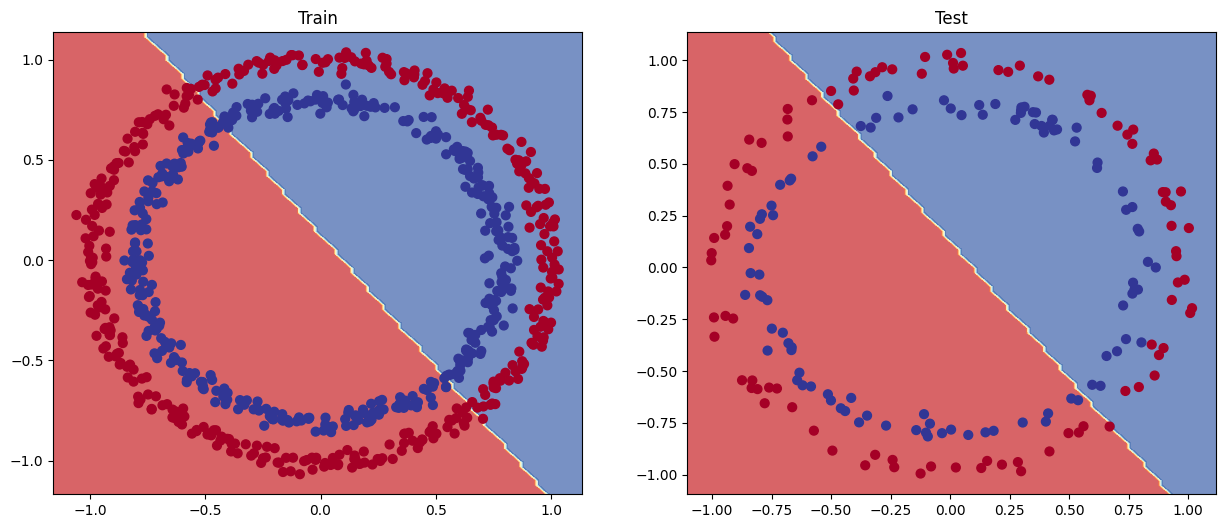

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1);
plt.title('Train');
plot_decision_boundary(model_0, X_train, y_train);
plt.subplot(1, 2, 2);
plt.title("Test");
plot_decision_boundary(model_0, X_test, y_test)

- Our model draws a straight line as a decision boundary betwee, the 2 classes.

- But it should draw a circle line.

## 10. Creating a new model with more layers and hidden units

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z


In [ ]:
# random_seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# create an instance of model1:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# create a loss function:
loss_fn = nn.BCEWithLogitsLoss()
# create an optimizer:
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
# random_seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs:
epochs = 1000
# put the data to device:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Build the training loop:
for epoch in range(epochs):
  ### training:
  model_1.train()
  # 1. forward pass:
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate loss/ acuracy:
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3.optimzer zero grad:
  optimizer.zero_grad()

  # 4. loss backward:
  loss.backward()

  # 5. optimizer step:
  optimizer.step()

  ### Testing:
  model_1.eval()
  with torch.inference_mode():
    # 1. forward pass:
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss:
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # print out:
    if epoch % 100 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc:50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc:50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc:51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc:51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc:51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69468, Test acc: 46.00%


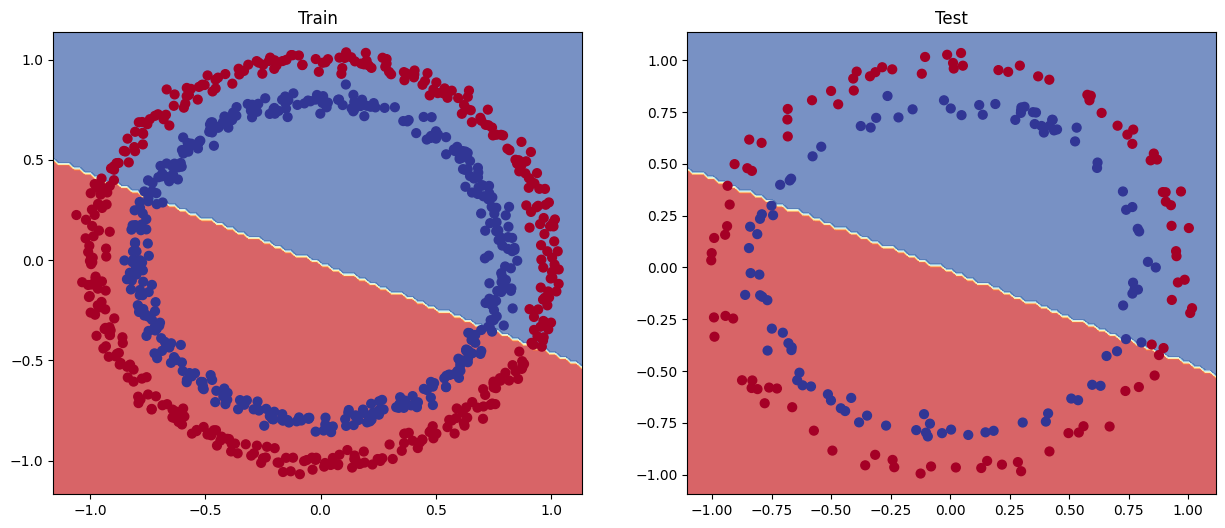

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1);
plt.title('Train');
plot_decision_boundary(model_1, X_train, y_train);
plt.subplot(1, 2, 2);
plt.title("Test");
plot_decision_boundary(model_1, X_test, y_test)

## 11. Building model with non-linearity

In [ ]:
# build the class model:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

In [ ]:
# model_v3:
model_2 = CircleModelV2()
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# create a loss function:
loss_fn = nn.BCEWithLogitsLoss()
# create an optimizer:
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

In [ ]:
# random_seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs:
epochs = 1000
# put the data to device:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Build the training loop:
for epoch in range(epochs):
  ### training:
  model_2.train()
  # 1. forward pass:
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate loss/ acuracy:
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3.optimzer zero grad:
  optimizer.zero_grad()

  # 4. loss backward:
  loss.backward()

  # 5. optimizer step:
  optimizer.step()

  ### Testing:
  model_2.eval()
  with torch.inference_mode():
    # 1. forward pass:
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss:
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # print out:
    if epoch % 100 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc:50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc:52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc:53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc:53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc:52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc:52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc:54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc:58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc:64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc:74.00% | Test loss: 0.62145, Test acc: 79.00%


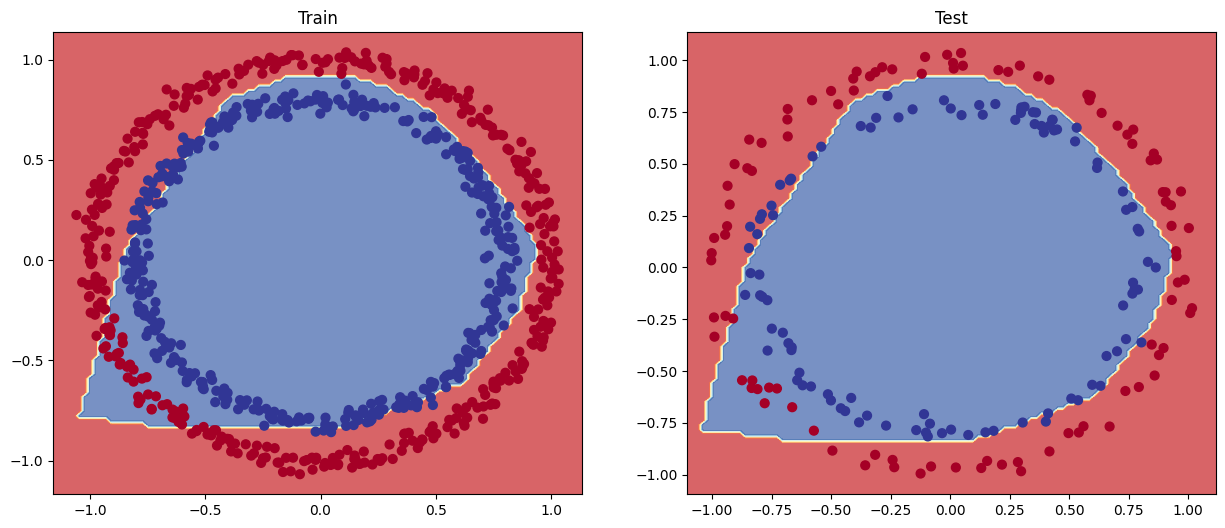

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1);
plt.title('Train');
plot_decision_boundary(model_2, X_train, y_train);
plt.subplot(1, 2, 2);
plt.title("Test");
plot_decision_boundary(model_2, X_test, y_test)

## 12. Evaluating a model trained with non-linear activation function

In [ ]:
# Make prdictions:
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 13. Replicating Non-Linear functions with pure PyTorch

In [ ]:
# create a tensor:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [ ]:
torch.relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [ ]:
# replicate a relu function:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

In [ ]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [ ]:
# replicate a sigmoid function:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

## 14. Multi-class classification

### 14.1 Multi-class Dataset

In [ ]:
# create the dataset:
from sklearn.datasets import make_blobs

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=4,
                            cluster_std=1.5,
                            random_state=42)


In [ ]:
# turn data into tensors:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [ ]:
# split the data:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                              y_blob,
                                                              test_size=0.2,
                                                              random_state=42)


### 14.2 Creating a multi-class classification model

In [ ]:
# build the classification model:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


In [ ]:
# create an instance of BlobModel:
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 14.3 Create a loss function and optimizer for our multiclass model

In [ ]:
# loss function for multi-classification:
loss_fn = nn.CrossEntropyLoss()

# optimizer:
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 14.4 Logits to prediction probabilities to labels

In [ ]:
# get some raw outputs of our model:
model_4.eval()
with torch.inference_mode():
  y_blob_logits = model_4(X_blob_test.to(device))
y_blob_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
# Get prediction probabilities:
y_blob_probs = torch.softmax(y_blob_logits, dim=1)
y_blob_probs[:10]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]])

In [ ]:
# Get labels:
y_blob_preds = torch.argmax(y_blob_probs, dim=1)
y_blob_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 14.5 Training a multi-class model

In [ ]:
# random_seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs:
epochs = 100
# put the data to device:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [ ]:
# Training loop:
for epoch in range(epochs):

  model_4.train()

  # calculate model output logits:
  y_blob_logits = model_4(X_blob_train)
  y_blob_preds = torch.softmax(y_blob_logits, dim=1).argmax(dim=1)

  # calculate the loss:
  loss = loss_fn(y_blob_logits, y_blob_train)
  # calculate the acc:
  acc = accuracy_fn(y_blob_train, y_blob_preds)

  # zero grad:
  optimizer.zero_grad()

  # backward:
  loss.backward()

  # step optimizer:
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_blob_logits = model_4(X_blob_test)
    test_blob_preds = torch.softmax(test_blob_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_blob_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_blob_preds)

  # print out what happen:
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")









Epoch: 0 | Loss: 1.06362, Acc:54.62% | Test loss: 1.00386, Test acc: 55.00%
Epoch: 10 | Loss: 0.62096, Acc:97.25% | Test loss: 0.63668, Test acc: 98.00%
Epoch: 20 | Loss: 0.40612, Acc:98.75% | Test loss: 0.41038, Test acc: 100.00%
Epoch: 30 | Loss: 0.23616, Acc:99.12% | Test loss: 0.22684, Test acc: 99.50%
Epoch: 40 | Loss: 0.10442, Acc:99.25% | Test loss: 0.09487, Test acc: 99.50%
Epoch: 50 | Loss: 0.06402, Acc:99.25% | Test loss: 0.05627, Test acc: 99.50%
Epoch: 60 | Loss: 0.04968, Acc:99.25% | Test loss: 0.04191, Test acc: 99.50%
Epoch: 70 | Loss: 0.04243, Acc:99.25% | Test loss: 0.03429, Test acc: 99.50%
Epoch: 80 | Loss: 0.03799, Acc:99.25% | Test loss: 0.02949, Test acc: 99.50%
Epoch: 90 | Loss: 0.03501, Acc:99.25% | Test loss: 0.02637, Test acc: 99.50%
